# CAPSTONE PROJECT

Our training script begins with a selection of imports. These include:

config: The configuration file consisting of paths and hyperparameters

VGG16: The CNN architecture to serve as the base network for our fine tuning approach

tf.keras: Imports from TensorFlow/Keras consisting of layer types, optimizers, and image loading/preprocessing routines

train_test_split: Scikit-learn’s convenience utility for slicing our network into training and testing subsets

matplotlib: Python’s de facto plotting package

numpy: Python’s standard numerical processing library

cv2: OpenCV

In [1]:
import os
import cv2
import csv
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from google.colab.patches import cv2_imshow


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
BASE_PATH = "/content/drive/My Drive/Capstone Data"
# define the path to the base output directory
BASE_OUTPUT = "output"

TRAIN_IMAGES_PATH = os.path.sep.join([BASE_PATH, "Car Images/Train Images"])
TEST_IMAGES_PATH = os.path.sep.join([BASE_PATH, "Car Images/Test Images"])
TRAIN_ANNOTS_PATH = os.path.sep.join([BASE_PATH, "Annotations/Train Annotations.csv"])
TEST_ANNOTS_PATH = os.path.sep.join([BASE_PATH, "Annotations/Test Annotation.csv"])
CAR_NAMES_MAKE_DICT = os.path.sep.join([BASE_PATH, "Car names and make.csv"])

# The path to our TensorFlow-serialized output model
MODEL_PATH = os.path.sep.join([BASE_PATH, BASE_OUTPUT, "detectorvgg16.h5"])
LB_PATH = os.path.sep.join([BASE_PATH, BASE_OUTPUT, "lb.pickle"])

# define the path to the output serialized model, model training plot,
# and testing image filenames
# A text file of image filenames selected for our testing set
TEST_FILENAMES = os.path.sep.join([BASE_PATH, BASE_OUTPUT, "test_images.txt"])
print(TEST_FILENAMES)


/content/drive/My Drive/Capstone Data/output/test_images.txt


In [6]:
car_map = pd.read_csv(CAR_NAMES_MAKE_DICT)
#car_map=car_map.set_index('Cars')


In [7]:
car_map.head()

,Cars,Class Numbers
0,AM General Hummer SUV 2000,1
1,Acura RL Sedan 2012,2
2,Acura TL Sedan 2012,3
3,Acura TL Type-S 2008,4
4,Acura TSX Sedan 2012,5


In [8]:
car_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Cars           196 non-null    object
 1   Class Numbers  196 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


In [9]:
car_map.columns = car_map.columns.str.replace(' ', '')

In [10]:
#print(car_map)
print(car_map.loc[car_map["ClassNumbers"] == 174])


print(car_map.loc[car_map["ClassNumbers"] == 174]["Cars"].values)

                               Cars  ClassNumbers
173  Ram C-V Cargo Van Minivan 2012           174
['Ram C-V Cargo Van Minivan 2012']


In [11]:
df_inittest= pd.read_csv(TEST_ANNOTS_PATH)

df_inittest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8041 entries, 0 to 8040
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Image Name                8041 non-null   object
 1   Bounding Box coordinates  8041 non-null   int64 
 2   Unnamed: 2                8041 non-null   int64 
 3   Unnamed: 3                8041 non-null   int64 
 4   Unnamed: 4                8041 non-null   int64 
 5   Image class               8041 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 377.0+ KB


In [38]:
df_tidytest = df_inittest.rename(columns = {'Bounding Box coordinates': 'StartX', 'Unnamed: 2' : 'StartY', 'Unnamed: 3':'EndX', 'Unnamed: 4':'EndY'}, inplace = False)

In [39]:
_Classname = []
TestFiles = []

for dfrow in tqdm(df_tidytest.iterrows()):
      
      lbl = dfrow[1]['Image class']

      keyName = str(car_map.loc[car_map["ClassNumbers"] == lbl]["Cars"].values)
      keyName = keyName.strip("[")
      keyName = keyName.strip("]")
      keyName = keyName.strip("'")

      fname = dfrow[1]['Image Name']
      imagePathtest = os.path.sep.join([TEST_IMAGES_PATH, keyName, fname])
      #print(imagePathtrain)

      _Classname.append(keyName)
      TestFiles.append(imagePathtest)

      
df_tidytest['Classname'] = _Classname
df_tidytest['Filepath'] = TestFiles

8041it [00:05, 1361.38it/s]


In [40]:
print(df_tidytest['Filepath'][0])
print(df_tidytest['Filepath'][1])
print(df_tidytest['Filepath'][2])
print(df_tidytest['Filepath'][3])

/content/drive/My Drive/Capstone Data/Car Images/Test Images/Suzuki Aerio Sedan 2007/00001.jpg
/content/drive/My Drive/Capstone Data/Car Images/Test Images/Ferrari 458 Italia Convertible 2012/00002.jpg
/content/drive/My Drive/Capstone Data/Car Images/Test Images/Jeep Patriot SUV 2012/00003.jpg
/content/drive/My Drive/Capstone Data/Car Images/Test Images/Toyota Camry Sedan 2012/00004.jpg


In [41]:
df_tidytest.head()

,Image Name,StartX,StartY,EndX,EndY,Image class,Classname,Filepath
0,00001.jpg,30,52,246,147,181,Suzuki Aerio Sedan 2007,/content/drive/My Drive/Capstone Data/Car Imag...
1,00002.jpg,100,19,576,203,103,Ferrari 458 Italia Convertible 2012,/content/drive/My Drive/Capstone Data/Car Imag...
2,00003.jpg,51,105,968,659,145,Jeep Patriot SUV 2012,/content/drive/My Drive/Capstone Data/Car Imag...
3,00004.jpg,67,84,581,407,187,Toyota Camry Sedan 2012,/content/drive/My Drive/Capstone Data/Car Imag...
4,00005.jpg,140,151,593,339,185,Tesla Model S Sedan 2012,/content/drive/My Drive/Capstone Data/Car Imag...


Display Sample image with bounding boxes

/content/drive/My Drive/Capstone Data/Car Images/Test Images/Mercedes-Benz Sprinter Van 2012/00272.jpg


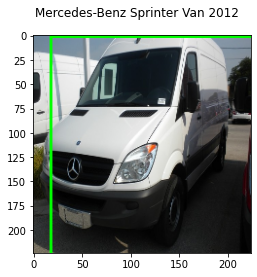

In [17]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd

#Pickup a random image number
img_num = np.random.randint(0, df_tidytest.shape[0])
#Read the image and draw a rectangle as per bounding box information
print(df_tidytest.loc[img_num,'Filepath'])
img = cv2.imread(df_tidytest.loc[img_num,'Filepath'])
img = cv2.resize(img,(224, 224))
(h, w) = img.shape[:2]
x_ratio = 224/w
y_ratio = 224/h
cv2.rectangle(img, 
             (int(df_tidytest.loc[img_num, 'StartX']*x_ratio),int(df_tidytest.loc[img_num, 'StartY']*y_ratio)),
             (int(df_tidytest.loc[img_num, 'EndX']*x_ratio),int(df_tidytest.loc[img_num, 'EndY']*y_ratio)), 
             (0,255,0),
             2)

#Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Draw image using matplotlib
plt.suptitle(df_tidytest.loc[img_num, 'Classname'])
plt.imshow(img)
plt.show()

In [18]:
import imutils

In [19]:
# load our object detector and label binarizer from disk
from tensorflow.keras.models import load_model
print("[INFO] loading object detector...")
model = load_model(MODEL_PATH)
lb = pickle.loads(open(LB_PATH, "rb").read())

[INFO] loading object detector...


In [42]:
predbboxes = []
predlabels = []
data = []
pX1 = []
pX2 = []
pY1 = []
pY2 = []

# loop over the images that we'll be testing using our bounding box
# regression model
for imagePath in tqdm(TestFiles):
	# load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image) / 255.0
  
  #data.append(image)

  image = np.expand_dims(image, axis=0)
	# predict the bounding box of the object along with the class
	# label
  (boxPreds, labelPreds) = model.predict(image)
  (startX, startY, endX, endY) = boxPreds[0]
	# determine the class label with the largest predicted
	# probability
  i = np.argmax(labelPreds, axis=1)
  label = lb.classes_[i][0]
  # load the input image (in OpenCV format), resize it such that it
	# fits on our screen, and grab its dimensions
  image = cv2.imread(imagePath)
  image = imutils.resize(image, width=600)
  (h, w) = image.shape[:2]
	# scale the predicted bounding box coordinates based on the image
	# dimensions
  startX = int(startX * w)
  startY = int(startY * h)
  endX = int(endX * w)
  endY = int(endY * h)

  #predbboxes.append((startX, startY, endX, endY))
  pX1.append(startX)
  pX2.append(endX)
  pY1.append(startY)
  pY2.append(endY)
  predlabels.append(label)


df_tidytest['predlbl'] = predlabels
df_tidytest['pX1'] = pX1
df_tidytest['pX2'] = pX2
df_tidytest['pY1'] = pY1
df_tidytest['pY2'] = pY2
#df_tidytest['testImage'] = data


100%|██████████| 8041/8041 [16:35<00:00,  8.08it/s]


In [43]:
df_tidytest.head()

,Image Name,StartX,StartY,EndX,EndY,Image class,Classname,Filepath,predlbl,pX1,pX2,pY1,pY2
0,00001.jpg,30,52,246,147,181,Suzuki Aerio Sedan 2007,/content/drive/My Drive/Capstone Data/Car Imag...,Honda Odyssey Minivan 2012,51,536,113,329
1,00002.jpg,100,19,576,203,103,Ferrari 458 Italia Convertible 2012,/content/drive/My Drive/Capstone Data/Car Imag...,Chrysler Crossfire Convertible 2008,85,527,29,209
2,00003.jpg,51,105,968,659,145,Jeep Patriot SUV 2012,/content/drive/My Drive/Capstone Data/Car Imag...,Land Rover LR2 SUV 2012,32,576,65,377
3,00004.jpg,67,84,581,407,187,Toyota Camry Sedan 2012,/content/drive/My Drive/Capstone Data/Car Imag...,Bentley Continental GT Coupe 2007,52,553,75,381
4,00005.jpg,140,151,593,339,185,Tesla Model S Sedan 2012,/content/drive/My Drive/Capstone Data/Car Imag...,Audi S6 Sedan 2011,119,549,151,338


In [44]:
for i in range(0,10):
    image_num = np.random.randint(0, df_tidytest.shape[0])
    #df.sample(n = 3)
    # draw the predicted bounding box and class label on the image
    startX = df_tidytest['pX1'][image_num]
    startY = df_tidytest['pY1'][image_num]
    endX = df_tidytest['pX2'][image_num]
    endY = df_tidytest['pY2'][image_num]

    imagePath = df_tidytest['Filepath'][image_num]

    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=600)
    label = df_tidytest['predlbl'][image_num]

    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,0.65, (0, 255, 0), 2)
    cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)

    # show the output image
    print('Actual Label:', df_tidytest['Classname'][image_num])
    cv2_imshow(image)
    cv2.waitKey(0)

Output hidden; open in https://colab.research.google.com to view.